<a href="https://colab.research.google.com/github/pxs1990/Data_Science_projects/blob/main/time_series_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **ARIMA and SARIMAX model to preict tesla price**

The ARIMA model with AR order p, differencing order d, and MA order q is specified as ARIMA(p,d,q). Let's break down what each component represents:

AR Order (p = 10):

The autoregressive (AR) order is the number of lagged observations included in the model. In this case, the model includes 10 lagged observations of the dependent variable.
Differencing Order (d = 1):

The differencing order represents the number of times the time series is differenced to achieve stationarity. In this case, the time series has undergone first-order differencing, indicating that the values are the differences between consecutive observations.
MA Order (q = 13):

The moving average (MA) order is the number of lagged forecast errors included in the model. In this case, the model includes 13 lagged forecast errors.

In [6]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pandas_datareader as pdr#gets financia data from API like yahoo, nasdaq
from scipy import stats
import seaborn as sns

In [5]:
!pip install yahoofinancials
from yahoofinancials import YahooFinancials

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.9/51.9 kB 2.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for yahoofinancials: filename=yahoofinancials-1.20-py3-none-any.whl size=38616 sha256=e0233e0ca4034479bb9a721ff32df8578b91ced2b42cb9ac84b51710f10127a0
  Stored in directory: /root/.cache/pip/wheels/cc/6b/dd/7ff776de4ebf7b144bb9562a813be59d0108306f368af9b637
Successfully built yahoofinancials


In [7]:
# Date must be in the fromat ("%Y-%m-%d") That is, year-month-day
# Importing the yfinance package
import yfinance as yf

# Set the start and end date
start_date = "2011-01-01"
end_date = "2024-01-31"

# Set the ticker
ticker = "TSLA"

# Get the data
tesla = yf.download(ticker, start_date, end_date)

# Print the last 5 rows
print(tesla.head())

[*********************100%%**********************]  1 of 1 completed

                Open      High       Low     Close  Adj Close    Volume
Date                                                                   
2011-01-03  1.789333  1.800000  1.726667  1.774667   1.774667  19245000
2011-01-04  1.777333  1.796667  1.734667  1.778000   1.778000  17811000
2011-01-05  1.765333  1.793333  1.746000  1.788667   1.788667  21700500
2011-01-06  1.788667  1.866667  1.787333  1.858667   1.858667  30918000
2011-01-07  1.866667  1.905333  1.860000  1.882667   1.882667  33718500


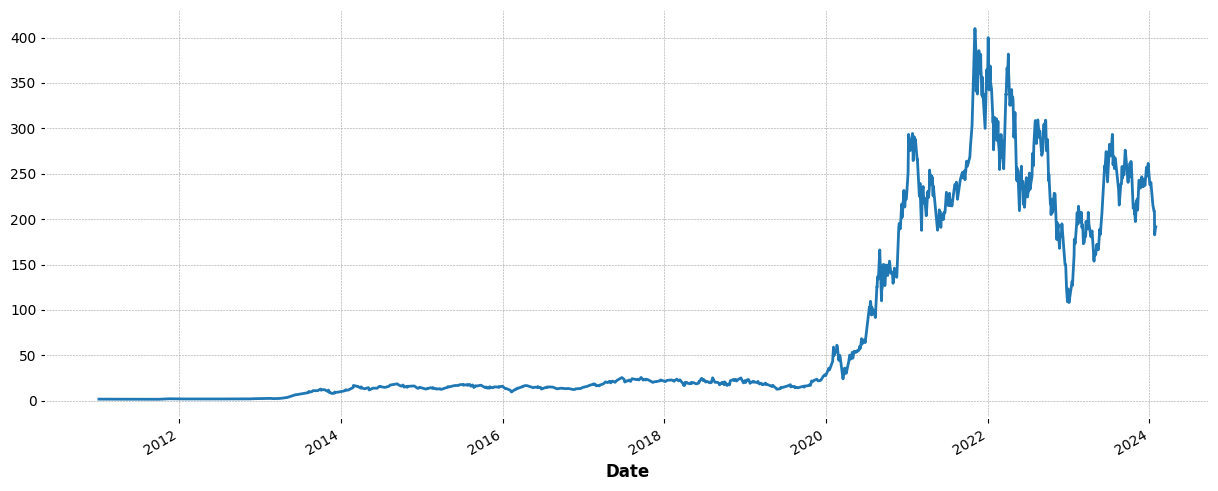

In [159]:
tesla['Adj Close'].plot(figsize=(15, 6))
plt.show()

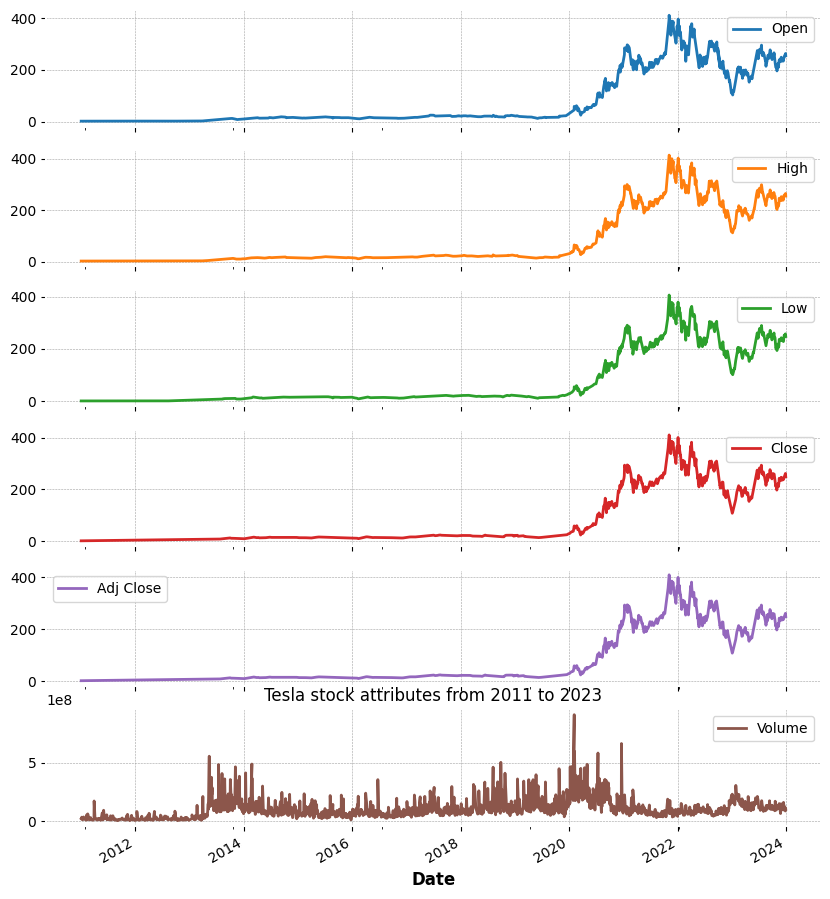

In [69]:
tesla['2011':'2023'].plot(subplots=True, figsize=(10,12))
plt.title('Tesla stock attributes from 2011 to 2023')
plt.savefig('stocks.png')
plt.show()


In [70]:
# viewing monthly avg of adj close
y = tesla['Adj Close'].resample('MS').mean()
print(y)
y_df=pd.DataFrame(y)
y_df

Date
2011-01-01      1.709533
2011-02-01      1.555579
2011-03-01      1.580580
2011-04-01      1.744400
2011-05-01      1.840857
                 ...    
2023-09-01    256.968000
2023-10-01    236.907727
2023-11-01    229.411905
2023-12-01    247.137998
2024-01-01    217.572501
Freq: MS, Name: Adj Close, Length: 157, dtype: float64


,Adj Close
Date,
2011-01-01,1.709533
2011-02-01,1.555579
2011-03-01,1.580580
2011-04-01,1.744400
2011-05-01,1.840857
...,...
2023-09-01,256.968000
2023-10-01,236.907727
2023-11-01,229.411905


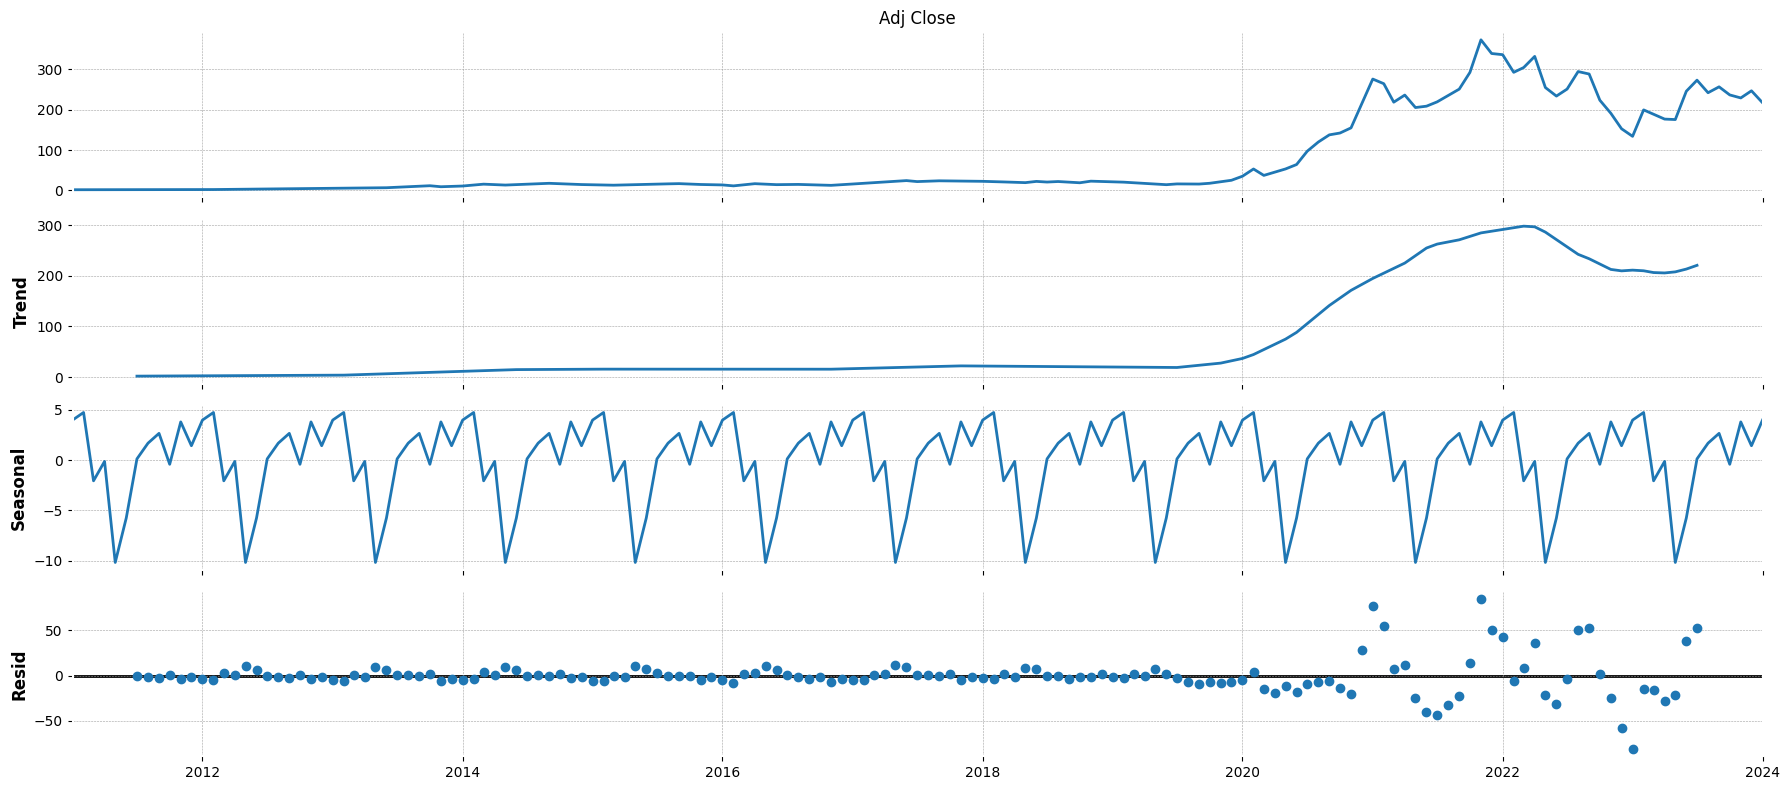

In [71]:
import numpy as np
import statsmodels.api as sm
#------------------------
from pylab import rcParams
rcParams['figure.figsize'] = 18, 8

decomposition = sm.tsa.seasonal_decompose(y, model='additive')
fig = decomposition.plot()
plt.show()

In [72]:
 y.isnull().sum()

0

<Axes: xlabel='Date'>

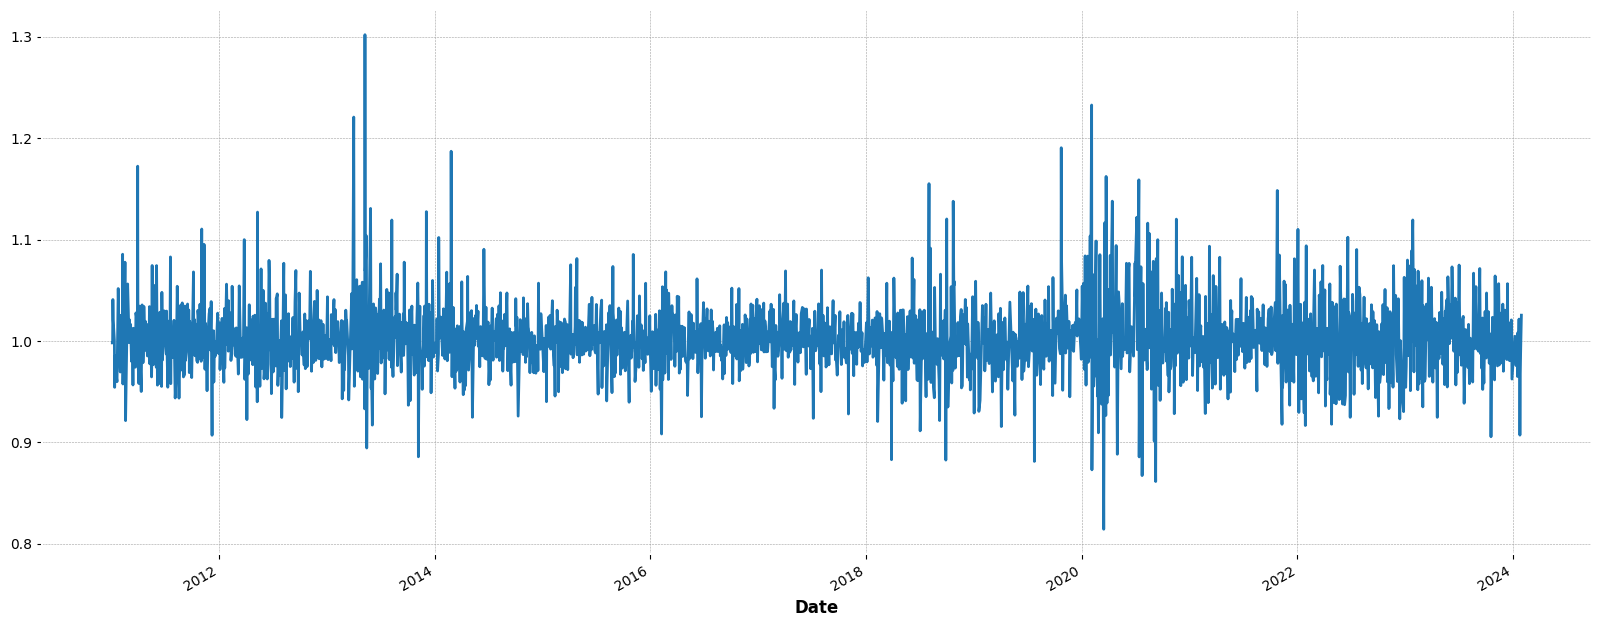

In [73]:
# daily change in the high prices of Tesla stock and create a new column called 'Change' in df
tesla['Change'] = tesla.High/(tesla.High.shift())
tesla['Change'].plot(figsize=(20,8))

<Axes: xlabel='Date'>

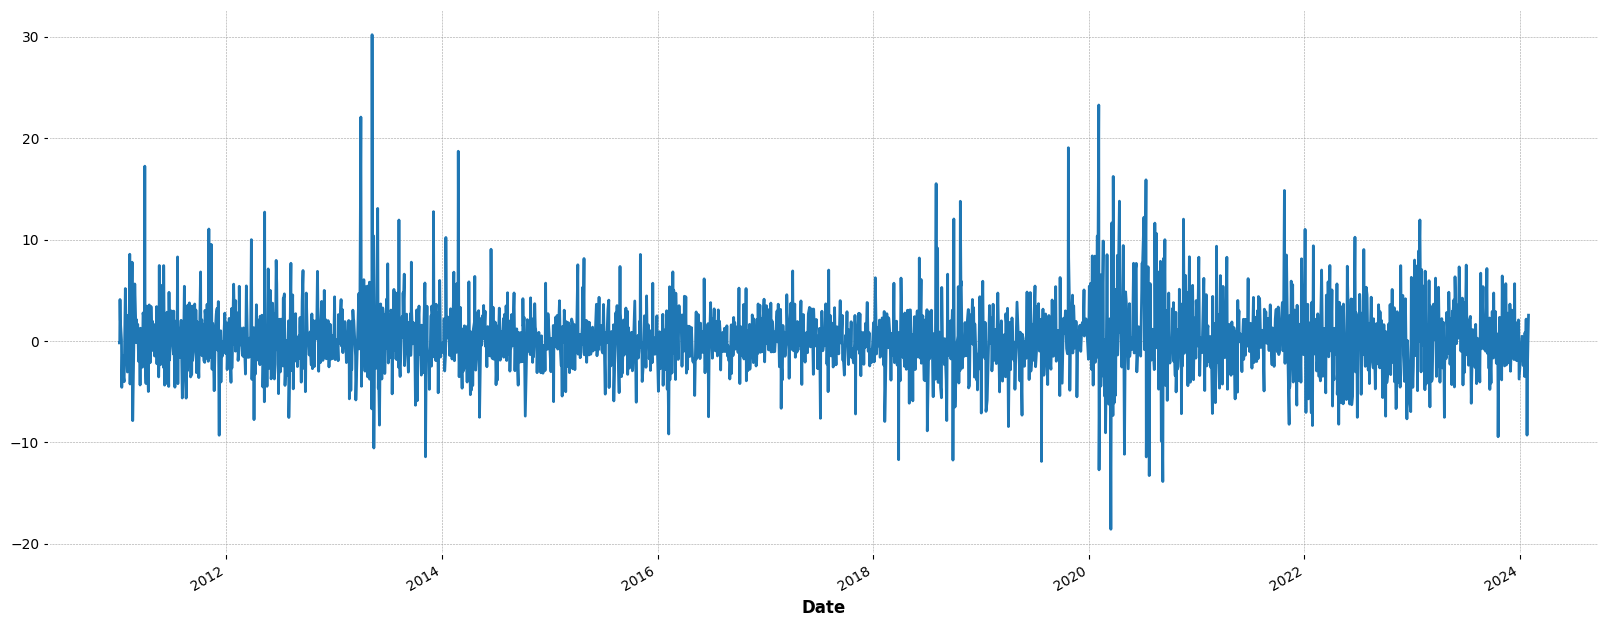

In [74]:
#tesla['Return'] = tesla.Change.sub(1).mul(100)
tesla['Return'] = (tesla['Change'] - 1) * 100
tesla['Return'].plot(figsize=(20,8))

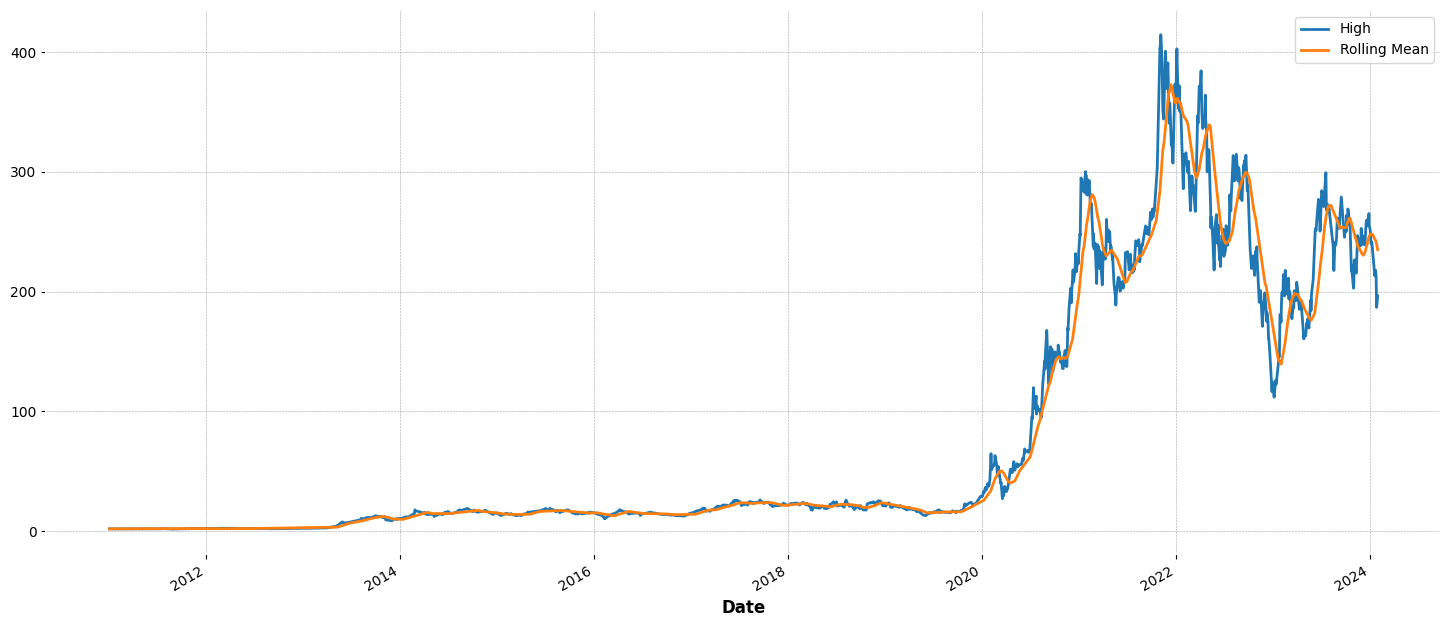

In [75]:
# Rolling window functions
rolling_tesla = tesla.High.rolling('50D').mean()
tesla.High.plot()
rolling_tesla.plot()
plt.legend(['High','Rolling Mean'])
# Plotting a rolling mean of 50 day window with original High attribute of tesla stocks

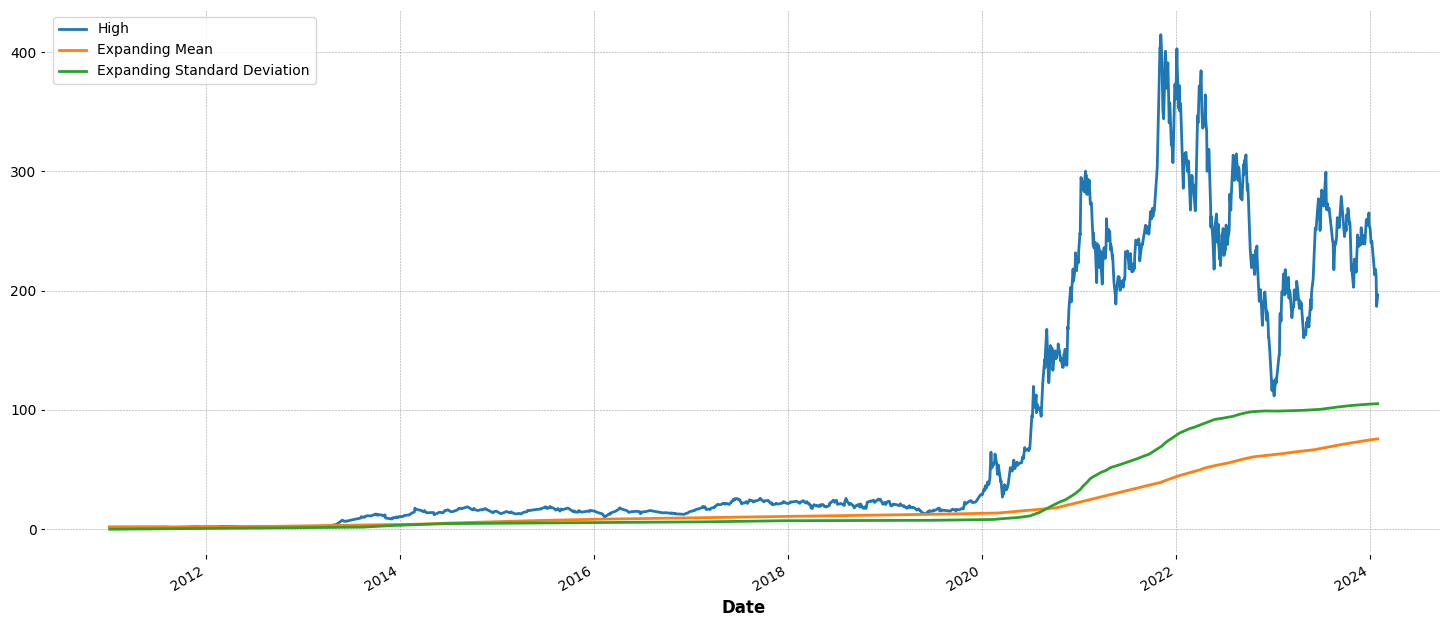

In [76]:
# Expanding window functions
tesla_mean = tesla.High.expanding().mean()#EM=cumulative mean=mean till today from the beginning
tesla_std = tesla.High.expanding().std()
tesla.High.plot()
tesla_mean.plot()
tesla_std.plot()
plt.legend(['High','Expanding Mean','Expanding Standard Deviation'])
plt.show()

# **OHLC charts**
OHLC charts, or Open-High-Low-Close charts, are a type of financial chart used to represent the price movement of a financial instrument over a specified time period. OHLC charts are widely used in technical analysis and are commonly used for visualizing the price dynamics of stocks, commodities, currencies, and other financial assets.

Here's a breakdown of the components in an OHLC chart:

Open (O): The opening price of the financial instrument at the beginning of the time period.

High (H): The highest price reached during the time period.

Low (L): The lowest price reached during the time period.

Close (C): The closing price of the financial instrument at the end of the time period.

Each data point on the chart is represented by a vertical line (the "wick" or "shadow") connecting the high and low prices, and a horizontal line (the "bar" or "candlestick body") representing the open and close prices. The direction of the close relative to the open determines the color of the candlestick (commonly green or white for a rising period and red or black for a falling period).
Colour can be assigned to each OHLC Chart symbol, to distinguish whether the market is "bullish" (the closing price is higher then it opened) or "bearish" (the closing price is lower then it opened).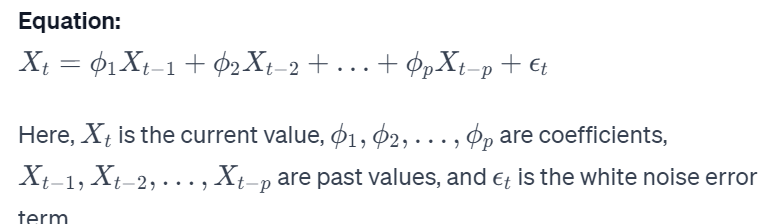

In [8]:
!pip install mplfinance

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.0/75.0 kB 1.4 MB/s eta 0:00:00


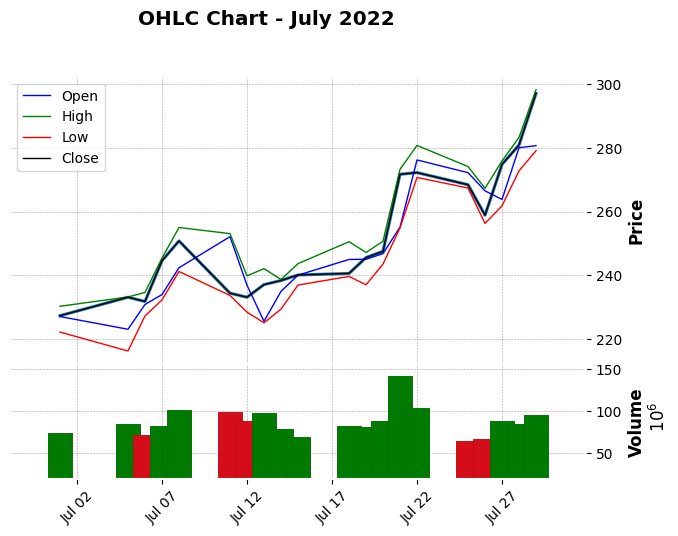

In [102]:
import matplotlib.pyplot as plt
import mplfinance as mpf
import pandas as pd

# Assuming 'tesla' is a DataFrame containing OHLC data for Tesla stock
# and the index of 'tesla' is a DateTimeIndex

# Filter the data for July 2022
start_date = '2022-07-01'
end_date = '2022-07-31'
tesla_july_2022 = tesla[start_date:end_date]

# Convert DataFrame to a format suitable for mplfinance
ohlc_data = tesla_july_2022[['Open', 'High', 'Low', 'Close', 'Volume']]
ohlc_data.index.name = 'Date'

# Create a custom legend with labels
custom_legend = [
    mpf.make_addplot(ohlc_data['Open'], panel=0, secondary_y=False, color='blue', label='Open',width=1),
    mpf.make_addplot(ohlc_data['High'], panel=0, secondary_y=False, color='green', label='High', width=1),
    mpf.make_addplot(ohlc_data['Low'], panel=0, secondary_y=False, color='red', label='Low',width=1),
    mpf.make_addplot(ohlc_data['Close'], panel=0, secondary_y=False, color='black', label='Close',width=1),
]

# Plot the OHLC lines with custom legend
mpf.plot(ohlc_data, type='line', style='charles', title='OHLC Chart - July 2022', ylabel='Price',
         ylabel_lower='Volume', volume=True, show_nontrading=True, addplot=custom_legend)

# Show the plot
plt.show()



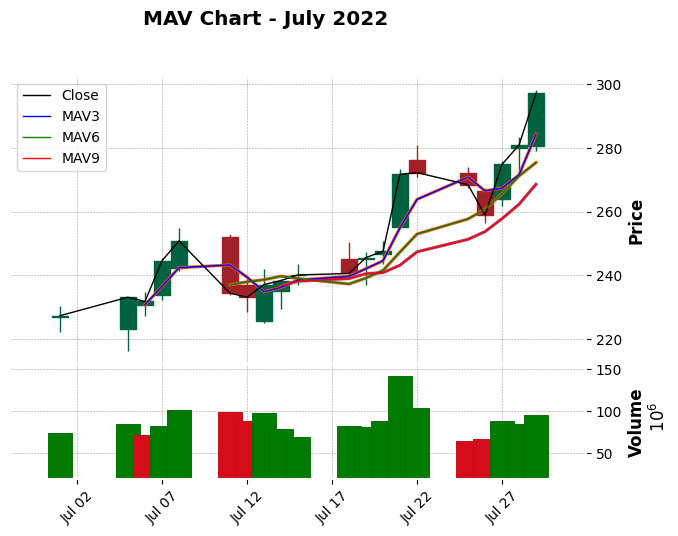

In [104]:
import matplotlib.pyplot as plt
import mplfinance as mpf
import pandas as pd

# Assuming 'tesla' is a DataFrame containing OHLC data for Tesla stock
# and the index of 'tesla' is a DateTimeIndex

# Filter the data for July 2022
start_date = '2022-07-01'
end_date = '2022-07-31'
tesla_july_2022 = tesla[start_date:end_date]

# Convert DataFrame to a format suitable for mplfinance
ohlc_data = tesla_july_2022[['Open', 'High', 'Low', 'Close', 'Volume']]
ohlc_data.index.name = 'Date'

# Calculate moving averages
for i in [3, 6, 9]:
    ohlc_data[f'MAV{i}'] = ohlc_data['Close'].rolling(window=i).mean()

# Create a custom legend with labels
custom_legend = [
    mpf.make_addplot(ohlc_data['Close'], panel=0, secondary_y=False, color='black', label='Close',width=1),
    mpf.make_addplot(ohlc_data['MAV3'], panel=0, secondary_y=False, color='blue', label='MAV3',width=1),
    mpf.make_addplot(ohlc_data['MAV6'], panel=0, secondary_y=False, color='green', label='MAV6',width=1),
    mpf.make_addplot(ohlc_data['MAV9'], panel=0, secondary_y=False, color='red', label='MAV9',width=1),
]

# Plot the OHLC chart with custom legend
mpf.plot(ohlc_data, type='candle', style='charles', mav=(3, 6, 9), title='MAV Chart - July 2022', ylabel='Price',
         ylabel_lower='Volume', volume=True, show_nontrading=True, addplot=custom_legend)

# Show the plot
plt.show()


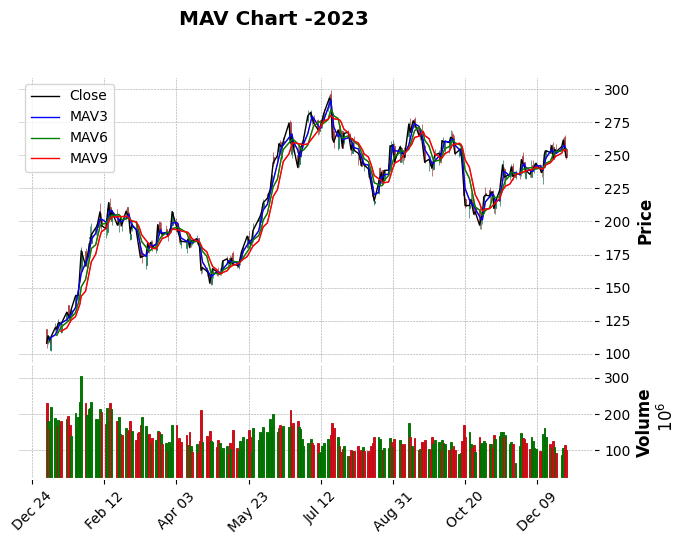

In [108]:
import matplotlib.pyplot as plt
import mplfinance as mpf
import pandas as pd

# Assuming 'tesla' is a DataFrame containing OHLC data for Tesla stock
# and the index of 'tesla' is a DateTimeIndex

# Filter the data for 2023
start_date = '2023-01-01'
end_date = '2023-12-31'
tesla_2023 = tesla[start_date:end_date]

# Convert DataFrame to a format suitable for mplfinance
ohlc_data = tesla_2023[['Open', 'High', 'Low', 'Close', 'Volume']]
ohlc_data.index.name = 'Date'

# Calculate moving averages
for i in [3, 6, 9]:
    ohlc_data[f'MAV{i}'] = ohlc_data['Close'].rolling(window=i).mean()

# Create a custom legend with labels
custom_legend = [
    mpf.make_addplot(ohlc_data['Close'], panel=0, secondary_y=False, color='black', label='Close',width=1),
    mpf.make_addplot(ohlc_data['MAV3'], panel=0, secondary_y=False, color='blue', label='MAV3',width=1),
    mpf.make_addplot(ohlc_data['MAV6'], panel=0, secondary_y=False, color='green', label='MAV6',width=1),
    mpf.make_addplot(ohlc_data['MAV9'], panel=0, secondary_y=False, color='red', label='MAV9',width=1),
]

# Plot the OHLC chart with custom legend
mpf.plot(ohlc_data, type='candle', style='charles', mav=(3, 6, 9), title='MAV Chart -2023', ylabel='Price',
         ylabel_lower='Volume', volume=True, show_nontrading=True, addplot=custom_legend)

# Show the plot
plt.show()

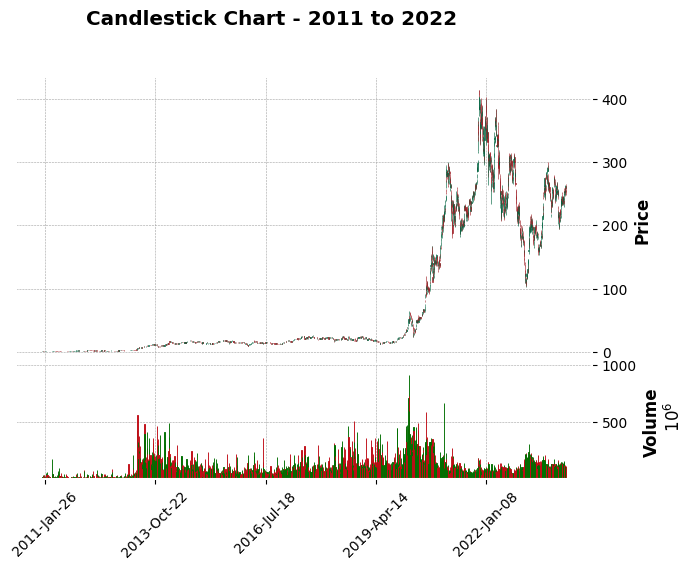

In [9]:
import matplotlib.pyplot as plt
import mplfinance as mpf
import pandas as pd

# Assuming 'tesla' is a DataFrame containing OHLC data for Tesla stock
# and the index of 'tesla' is a DateTimeIndex

# Filter the data for 2011 to 2023
start_date = '2011-01-01'
end_date = '2023-12-31'
tesla_2011_to_2023 = tesla[start_date:end_date]

# Convert DataFrame to a format suitable for mplfinance
ohlc_data = tesla_2011_to_2023[['Open', 'High', 'Low', 'Close', 'Volume']]
ohlc_data.index.name = 'Date'

# Plot the OHLC chart (only candlestick)
mpf.plot(ohlc_data, type='candle', style='charles', title='Candlestick Chart - 2011 to 2022', ylabel='Price',
         ylabel_lower='Volume', volume=True, show_nontrading=True)

# Show the plot
plt.show()


# **Autocorrelation and Partial Autocorrelation**
Autocorrelation (ACF) and Partial Autocorrelation (PACF) are statistical tools used in time series analysis to identify the presence of autocorrelation in a dataset.

**Autocorrelation Function (ACF):**

Autocorrelation measures the correlation between a time series and a lagged version of itself(lag=time difference betn observations in a time series).
The ACF at lag k, denoted as ACF(k), is calculated as the correlation between the time series values at time t and the values at time t - k.
The ACF helps to identify the overall pattern of dependence within the time series.

**Partial Autocorrelation Function (PACF):**
The PACF helps in identifying the order of the AutoRegressive (AR) process by showing the direct relationship between each lag and the current observation, after removing the effects of the intervening lags.

PACF measures the correlation between a time series and a lagged version of itself while controlling for the effect of other lags.
The PACF at lag k, denoted as PACF(k), represents the correlation between the time series values at time t and the values at time t - k, with the linear dependence of the intermediate lags (t - 1, t - 2, ..., t - k + 1) removed.
The PACF helps to identify the direct relationship between the current and lagged values.
Both ACF and PACF are commonly used in the Box-Jenkins methodology for time series analysis, particularly in the identification phase of building ARIMA (AutoRegressive Integrated Moving Average) models.

ACF:

If ACF shows a sharp drop-off after a certain lag, it suggests that there is no autocorrelation beyond that lag.
If ACF shows a slow decay, it indicates a long memory in the time series.
PACF:

If PACF has a sharp drop-off after a certain lag, it suggests that the lag is a potentially good candidate for the order of the autoregressive (AR) component in an ARIMA model.
Significant spikes in PACF at certain lags may indicate the order of the autoregressive component.

**Auto Correlation**

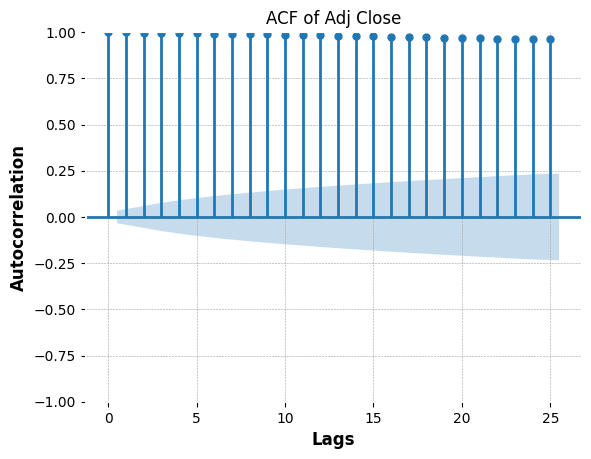

In [5]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Plot ACF
plot_acf(tesla["Adj Close"], lags=25, title="ACF of Adj Close")
plt.xlabel("Lags")
plt.ylabel("Autocorrelation")
plt.show()

With  25 lags with a positive correlation above 0.25 there's a good chance that the time series has a stochastic trend, and will need a significant level of differencing( taking the difference between consecutive observations) to achieve stationarity.
We are not able to find the order of MA as correlations in all lags are within CI(insignificant)

**Partial Autocorrelation PACF**

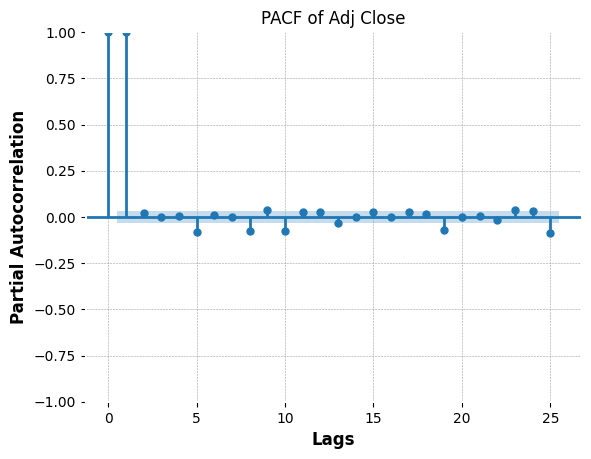

In [6]:
plot_pacf(tesla["Adj Close"], lags=25, title="PACF of Adj Close")
plt.xlabel("Lags")
plt.ylabel("Partial Autocorrelation")
plt.show()

There is significant correlation in lag and  and in the subsiquent lags, correlations are with in the CI. This might be indicative of a simple autoregressive structure, possibly an AR(1) process, where each observation is primarily influenced by the one just before it.




Since there is no clear-cut result about the lags of the MA model because of continuously persistant autocorrelation(significant), we are going to choose the auto-lag-selection ARIMA model.

**Autoregressive (AR) Model:**
An Autoregressive (AR) model is a type of time series model where the current value of a variable is predicted as a linear combination of its past values. The "autoregressive" part indicates that the model uses its own past values for prediction.
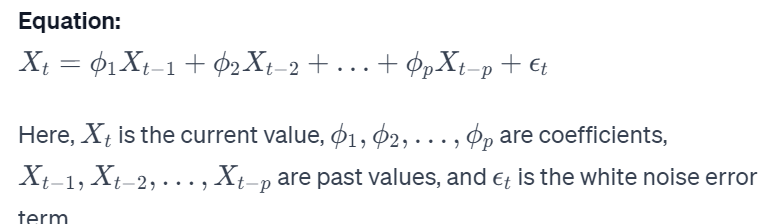

Purpose:
MA models help capture short-term fluctuations in time series data by modeling the influence of past error terms. They are suitable when there is a correlation between the current value and past errors.


In [10]:
import pandas as pd
!pip install pmdarima

from pmdarima.arima import auto_arima
import pmdarima as pm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 33.2 MB/s eta 0:00:00


In [ ]:
# # Assuming 'data' is a pandas Series containing time series data

# # Fit the ARIMA model with automatic lag selection
# model = auto_arima(tesla['Adj Close'], seasonal=False, trace=True)

# # Summary of the best ARIMA model selected
# print(model.summary())

In [12]:
X=tesla.drop(columns=['Adj Close'])
y=tesla['Adj Close']

In [10]:
from sklearn.model_selection import TimeSeriesSplit

tss = TimeSeriesSplit(n_splits=10)
for train_index, test_index in tss.split(X):
    X_train, X_test = X.iloc[train_index, :], X.iloc[test_index,:]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

In [127]:
X_train.index

DatetimeIndex(['2011-01-03', '2011-01-04', '2011-01-05', '2011-01-06',
               '2011-01-07', '2011-01-10', '2011-01-11', '2011-01-12',
               '2011-01-13', '2011-01-14',
               ...
               '2021-11-09', '2021-11-10', '2021-11-11', '2021-11-12',
               '2021-11-15', '2021-11-16', '2021-11-17', '2021-11-18',
               '2021-11-19', '2021-11-22'],
              dtype='datetime64[ns]', name='Date', length=2742, freq=None)

In [128]:
X_test.index

DatetimeIndex(['2021-11-23', '2021-11-24', '2021-11-26', '2021-11-29',
               '2021-11-30', '2021-12-01', '2021-12-02', '2021-12-03',
               '2021-12-06', '2021-12-07',
               ...
               '2024-01-17', '2024-01-18', '2024-01-19', '2024-01-22',
               '2024-01-23', '2024-01-24', '2024-01-25', '2024-01-26',
               '2024-01-29', '2024-01-30'],
              dtype='datetime64[ns]', name='Date', length=548, freq=None)

In [11]:
model =  auto_arima(y_train, seasonal=False, trace=True)
print(model.summary())

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=17438.740, Time=2.17 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=17436.722, Time=0.10 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=17433.601, Time=0.17 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=17433.747, Time=0.46 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=17435.274, Time=0.08 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=17435.031, Time=0.43 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=17434.740, Time=1.00 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=17436.738, Time=2.10 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=17432.202, Time=0.12 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=17433.614, Time=0.20 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=17433.325, Time=0.71 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=17432.348, Time=0.19 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=17435.600, Time=0.27 sec

Best model:  ARIMA(1,1,0)(0,0,0)[0]          
Total fit time: 8.043 seconds
         

In [169]:
model.get_params()

{'maxiter': 50,
 'method': 'lbfgs',
 'order': (1, 1, 0),
 'out_of_sample_size': 0,
 'scoring': 'mse',
 'scoring_args': {},
 'seasonal_order': (0, 0, 0, 0),
 'start_params': None,
 'suppress_warnings': True,
 'trend': None,
 'with_intercept': False}

In [171]:
model.get_params()['order'][1]

1

In [ ]:

def plot_result(model, data, col_name, Ntest):

    params = model.get_params()
    d = params['order'][1]

    #In sample data prediction
    train_pred = model.predict_in_sample(start=d, end=-1)
    #out of sample prediction
    test_pred, conf = model.predict(n_periods=Ntest, return_conf_int=True)

    #plotting real values, fitted values and prediction values
    fig, ax= plt.subplots(figsize=(15,8))
    ax.plot(data[col_name].index, data[col_name], label='Actual Values')
    ax.plot(train.index[d:], train_pred, color='green', label='Fitted Values')
    ax.plot(test.index, test_pred, label='Forecast Values')
    ax.fill_between(test.index, conf[:,0], conf[:,1], color='red', alpha=0.3)
    ax.legend()

    #evaluating the model using RMSE and MAE metrics
    y_true = test[col_name].values
    rmse = np.sqrt(mean_squared_error(y_true,test_pred))
    mae = mean_absolute_error(y_true,test_pred)

    return rmse, mae


**Predicting from the model**

In [166]:
# Make predictions
forecast, conf_int = model.predict(n_periods=10, return_conf_int=True)

In [167]:
print("Forecasted Values:")
print(forecast.values)

Forecasted Values:
[183.32436252 183.31800829 183.31826985 183.31825909 183.31825953
 183.31825951 183.31825951 183.31825951 183.31825951 183.31825951]


In [147]:
print(conf_int)# 2d of up and lower bound

[[387.08749073 399.86949612]
 [392.72793577 411.97904414]
 [397.96332099 423.56807302]
 [402.51231585 435.49678364]
 [406.841035   448.20102833]]


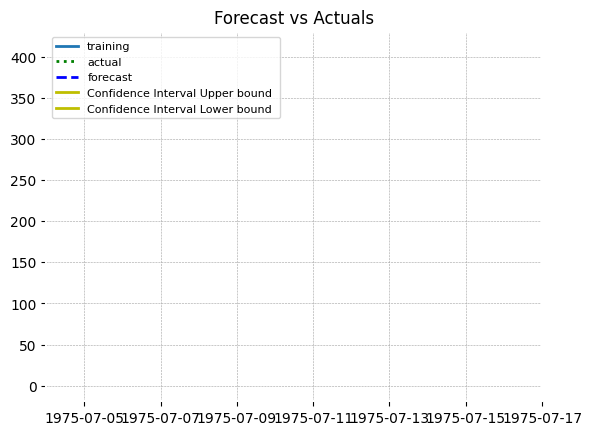

In [168]:
# Make as pandas series
forcast_series = pd.Series(forecast, index=y_test.index)
lower_bound = pd.Series(conf_int[:, 0])
upper_bound = pd.Series(conf_int[:, 1])

# Plot
plt.plot(y_train, label='training')
plt.plot(y_test, 'g:', label='actual')
plt.plot(forcast_series,'b--', label='forecast')
plt.fill_between(lower_bound.index, lower_bound, upper_bound ,
                 color='b', alpha=.2)
plt.plot(lower_bound, color= 'y',label='Confidence Interval Upper bound ')
plt.plot(upper_bound, color= 'y',label='Confidence Interval Lower bound ')
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.xlim(2010,2023)
plt.show()

In [13]:
from pmdarima.arima.utils import ndiffs

# Calculate the number of differences needed for stationarity
d_val = ndiffs(tesla['Adj Close'], test='adf')

# Print the calculated differencing parameter
print('Arima D-value:', d_val)
#type of test to be used for determining the number of differences needed to achieve stationarity.
#In this case, 'adf' stands for the Augmented Dickey-Fuller (ADF) test.

Arima D-value: 1


In [14]:
#splitting the data to train and test sets based on Ntest value
#last 500 days
Ntest = 500
train = tesla.iloc[:-Ntest]
test = tesla.iloc[-Ntest:]
train_idx = tesla.index <= train.index[-1]
test_idx = tesla.index > train.index[-1]

#Define auto-arima to find best model
model = pm.auto_arima(train['Close'],
                      d =d_val ,
                      start_p = 0,
                      max_p = 6,
                      start_q = 0,
                      max_q = 5,
                      stepwise=False,
                      max_order=5,# truncates iteration after 5 if p or q >5
                      trace=True)

 ARIMA(0,1,0)(0,0,0)[1] intercept   : AIC=15115.199, Time=0.12 sec
 ARIMA(0,1,1)(0,0,0)[1] intercept   : AIC=15113.568, Time=0.81 sec
 ARIMA(0,1,2)(0,0,0)[1] intercept   : AIC=15115.054, Time=1.19 sec
 ARIMA(0,1,3)(0,0,0)[1] intercept   : AIC=15109.624, Time=1.00 sec
 ARIMA(0,1,4)(0,0,0)[1] intercept   : AIC=15111.260, Time=1.30 sec
 ARIMA(0,1,5)(0,0,0)[1] intercept   : AIC=15107.839, Time=2.03 sec
 ARIMA(1,1,0)(0,0,0)[1] intercept   : AIC=15113.682, Time=0.22 sec
 ARIMA(1,1,1)(0,0,0)[1] intercept   : AIC=15115.435, Time=1.32 sec
 ARIMA(1,1,2)(0,0,0)[1] intercept   : AIC=15104.619, Time=1.75 sec
 ARIMA(1,1,3)(0,0,0)[1] intercept   : AIC=15103.491, Time=2.24 sec
 ARIMA(1,1,4)(0,0,0)[1] intercept   : AIC=15105.362, Time=4.18 sec
 ARIMA(2,1,0)(0,0,0)[1] intercept   : AIC=15114.745, Time=0.50 sec
 ARIMA(2,1,1)(0,0,0)[1] intercept   : AIC=15103.753, Time=2.27 sec
 ARIMA(2,1,2)(0,0,0)[1] intercept   : AIC=inf, Time=6.13 sec
 ARIMA(2,1,3)(0,0,0)[1] intercept   : AIC=15104.019, Time=4.70 sec
 

In [15]:
model.get_params()

{'maxiter': 50,
 'method': 'lbfgs',
 'order': (3, 1, 1),
 'out_of_sample_size': 0,
 'scoring': 'mse',
 'scoring_args': {},
 'seasonal_order': (0, 0, 0, 1),
 'start_params': None,
 'suppress_warnings': True,
 'trend': None,
 'with_intercept': True}

In [16]:
def plot_result(model, data, col_name, Ntest):

    params = model.get_params()
    d = params['order'][1]

    #In sample data prediction
    train_pred = model.predict_in_sample(start=d, end=-1)
    #out of sample prediction
    test_pred, conf = model.predict(n_periods=Ntest, return_conf_int=True)

    #plotting real values, fitted values and prediction values
    fig, ax= plt.subplots(figsize=(15,8))
    ax.plot(data[col_name].index, data[col_name], label='Actual Values')
    ax.plot(train.index[d:], train_pred, color='green', label='Fitted Values')
    ax.plot(test.index, test_pred, label='Forecast Values')
    ax.fill_between(test.index, conf[:,0], conf[:,1], color='red', alpha=0.3)
    ax.legend()

    #evaluating the model using RMSE and MAE metrics
    y_true = test[col_name].values
    rmse = np.sqrt(mean_squared_error(y_true,test_pred))
    mae = mean_absolute_error(y_true,test_pred)

    return rmse, mae

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


Root Mean Squared Error:  119.69709761688591
Mean Absolute Error:  106.82049353712392


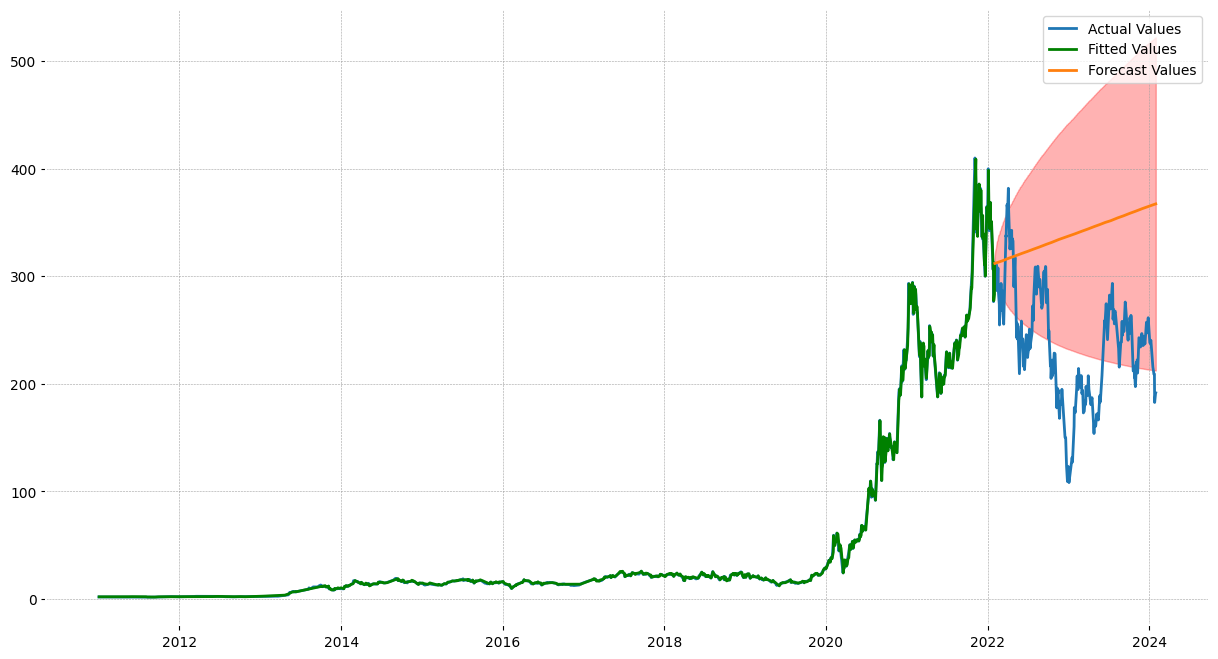

In [19]:
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
rmse , mae = plot_result(model, tesla, 'Close', Ntest=500)
print('Root Mean Squared Error: ', rmse)
print('Mean Absolute Error: ', mae)

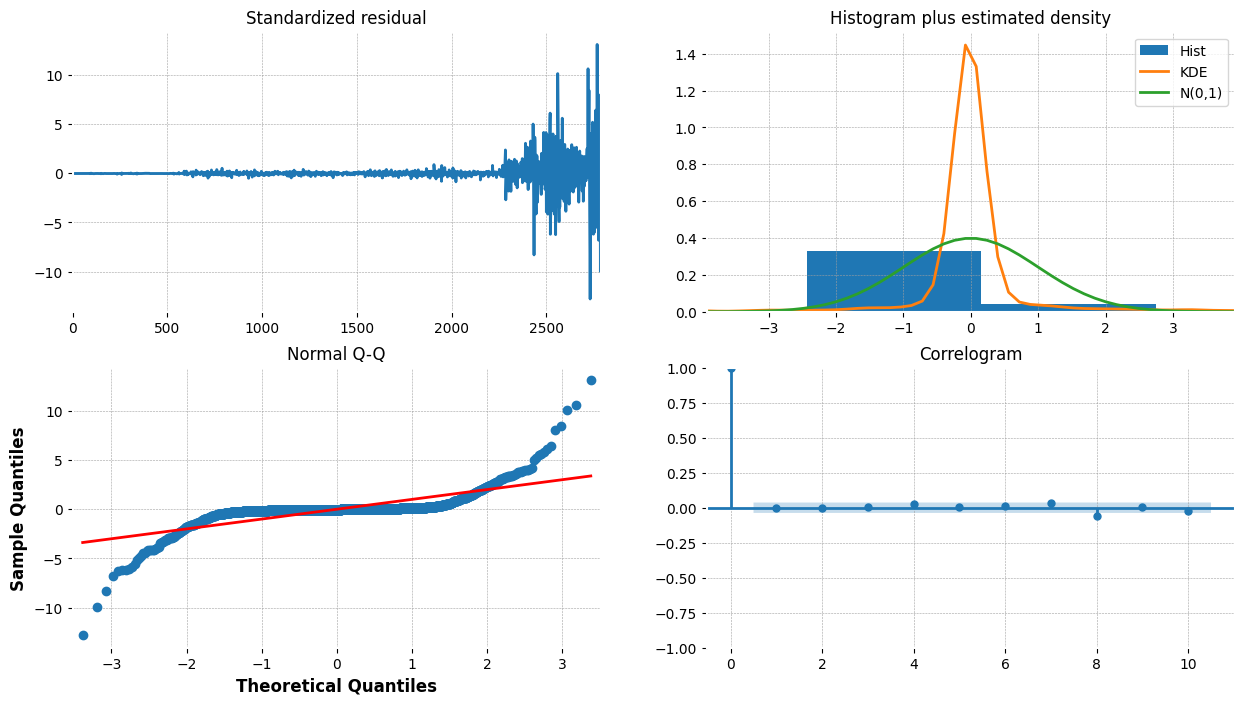

In [20]:
model.plot_diagnostics(figsize=(15,8))
plt.show()


In [ ]:
#hist is left skewed. Data is not perfectly normal. Lets add Seasonality.

# **Seasonality**

In [21]:
tesla.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2011-01-03,1.789333,1.800000,1.726667,1.774667,1.774667,19245000
2011-01-04,1.777333,1.796667,1.734667,1.778000,1.778000,17811000
2011-01-05,1.765333,1.793333,1.746000,1.788667,1.788667,21700500
2011-01-06,1.788667,1.866667,1.787333,1.858667,1.858667,30918000
2011-01-07,1.866667,1.905333,1.860000,1.882667,1.882667,33718500


In [23]:
y = tesla['Adj Close'].resample('MS').mean()
y

Date
2011-01-01      1.709533
2011-02-01      1.555579
2011-03-01      1.580580
2011-04-01      1.744400
2011-05-01      1.840857
                 ...    
2023-09-01    256.968000
2023-10-01    236.907727
2023-11-01    229.411905
2023-12-01    247.137998
2024-01-01    217.572501
Freq: MS, Name: Adj Close, Length: 157, dtype: float64

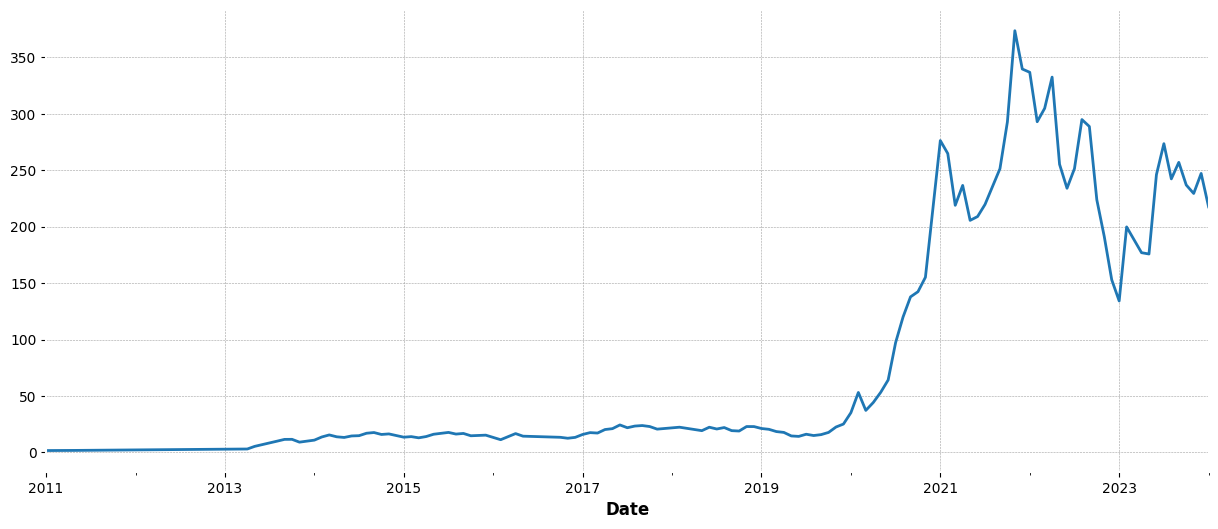

In [24]:
y.plot(figsize=(15, 6))
plt.show()

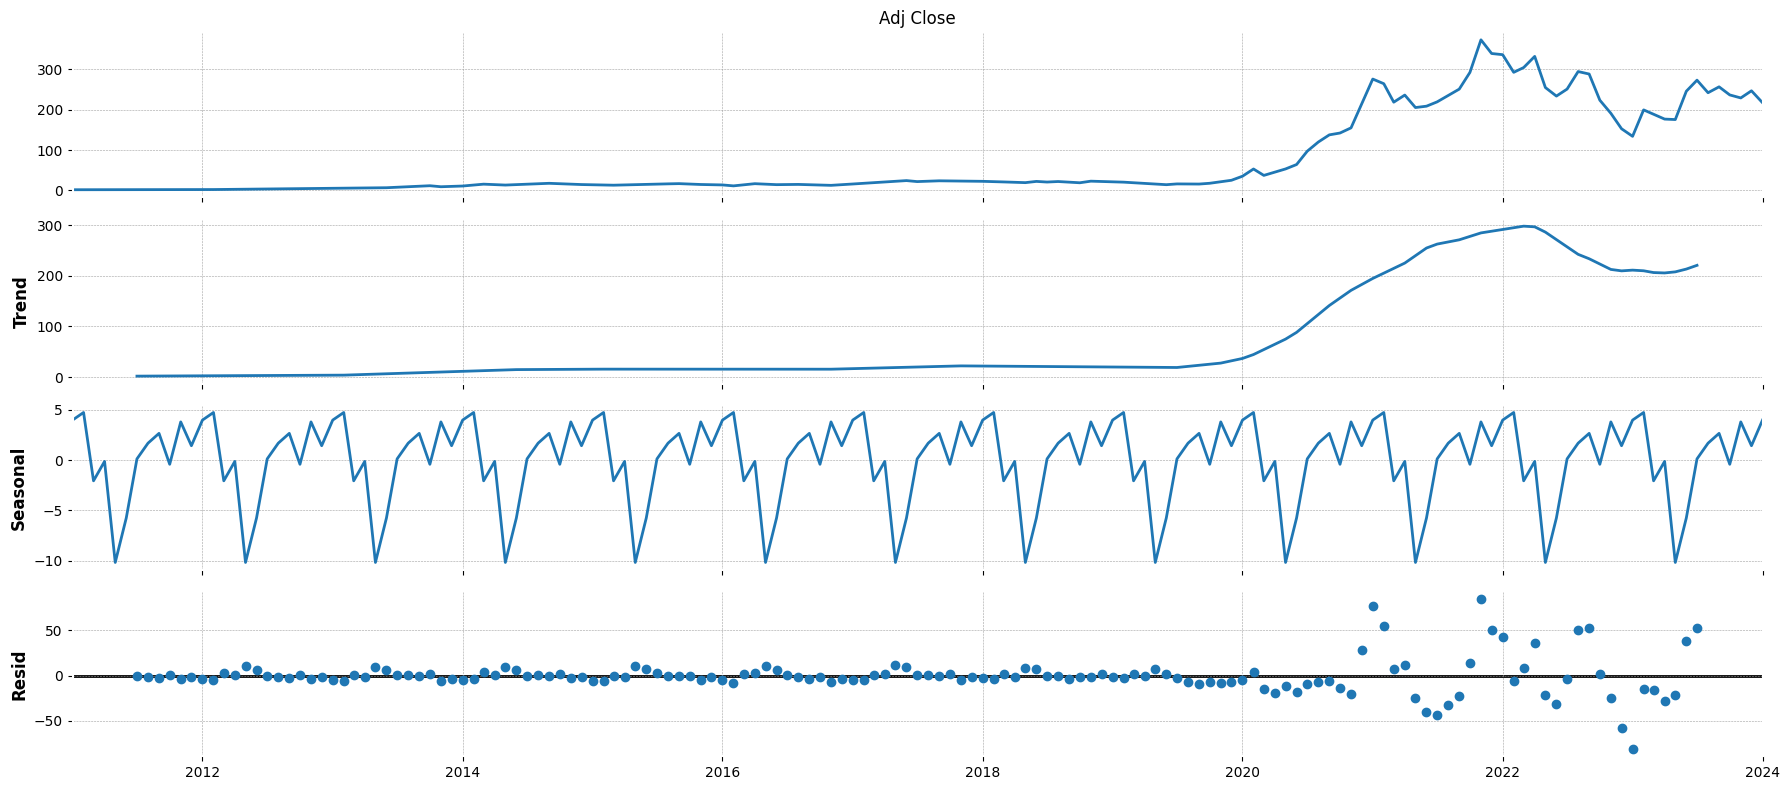

In [26]:
from pylab import rcParams
import statsmodels.api as sm

rcParams['figure.figsize'] = 18, 8

decomposition = sm.tsa.seasonal_decompose(y, model='additive')
fig = decomposition.plot()
plt.show()

In [27]:
import itertools
p = d = q = range(0, 2)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

print('Examples of parameter combinations for Seasonal ARIMA...')
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[3]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[4]))

Examples of parameter combinations for Seasonal ARIMA...
SARIMAX: (0, 0, 1) x (0, 0, 1, 12)
SARIMAX: (0, 0, 1) x (0, 1, 0, 12)
SARIMAX: (0, 1, 0) x (0, 1, 1, 12)
SARIMAX: (0, 1, 0) x (1, 0, 0, 12)


In [28]:
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(y,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)

            results = mod.fit()

            print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))
        except:
            continue

ARIMA(0, 0, 0)x(0, 0, 0, 12)12 - AIC:1955.91337264094
ARIMA(0, 0, 0)x(0, 0, 1, 12)12 - AIC:1703.0103120288372
ARIMA(0, 0, 0)x(0, 1, 0, 12)12 - AIC:1627.2953690228173
ARIMA(0, 0, 0)x(0, 1, 1, 12)12 - AIC:1502.4113523246647
ARIMA(0, 0, 0)x(1, 0, 0, 12)12 - AIC:1639.4846081392084
ARIMA(0, 0, 0)x(1, 0, 1, 12)12 - AIC:1625.0769221366488
ARIMA(0, 0, 0)x(1, 1, 0, 12)12 - AIC:1514.7060812489326
ARIMA(0, 0, 0)x(1, 1, 1, 12)12 - AIC:1500.870133438047
ARIMA(0, 0, 1)x(0, 0, 0, 12)12 - AIC:1746.066444063218
ARIMA(0, 0, 1)x(0, 0, 1, 12)12 - AIC:1525.720982946915
ARIMA(0, 0, 1)x(0, 1, 0, 12)12 - AIC:1455.029226057774
ARIMA(0, 0, 1)x(0, 1, 1, 12)12 - AIC:1345.59198213598
ARIMA(0, 0, 1)x(1, 0, 0, 12)12 - AIC:1475.872495659357
ARIMA(0, 0, 1)x(1, 0, 1, 12)12 - AIC:1459.3002770878097
ARIMA(0, 0, 1)x(1, 1, 0, 12)12 - AIC:1364.0323387817489
ARIMA(0, 0, 1)x(1, 1, 1, 12)12 - AIC:1347.5919584505386
ARIMA(0, 1, 0)x(0, 0, 0, 12)12 - AIC:1354.2221454305704
ARIMA(0, 1, 0)x(0, 0, 1, 12)12 - AIC:1262.240250340989
AR

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(1, 0, 0)x(0, 0, 1, 12)12 - AIC:1273.5509836467313
ARIMA(1, 0, 0)x(0, 1, 0, 12)12 - AIC:1357.1612361786274
ARIMA(1, 0, 0)x(0, 1, 1, 12)12 - AIC:1193.091800869738
ARIMA(1, 0, 0)x(1, 0, 0, 12)12 - AIC:1272.1703430771076
ARIMA(1, 0, 0)x(1, 0, 1, 12)12 - AIC:1274.0406988539162
ARIMA(1, 0, 0)x(1, 1, 0, 12)12 - AIC:1226.260825289613
ARIMA(1, 0, 0)x(1, 1, 1, 12)12 - AIC:1198.610094139589
ARIMA(1, 0, 1)x(0, 0, 0, 12)12 - AIC:1353.107016447905


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(1, 0, 1)x(0, 0, 1, 12)12 - AIC:1262.8454923498578
ARIMA(1, 0, 1)x(0, 1, 0, 12)12 - AIC:1331.477486085153
ARIMA(1, 0, 1)x(0, 1, 1, 12)12 - AIC:1180.9443292750684
ARIMA(1, 0, 1)x(1, 0, 0, 12)12 - AIC:1269.9814733632422
ARIMA(1, 0, 1)x(1, 0, 1, 12)12 - AIC:1264.1962667236926
ARIMA(1, 0, 1)x(1, 1, 0, 12)12 - AIC:1217.7755411697565
ARIMA(1, 0, 1)x(1, 1, 1, 12)12 - AIC:1185.9270054411213
ARIMA(1, 1, 0)x(0, 0, 0, 12)12 - AIC:1352.8037652743387
ARIMA(1, 1, 0)x(0, 0, 1, 12)12 - AIC:1261.411462017481
ARIMA(1, 1, 0)x(0, 1, 0, 12)12 - AIC:1345.7332042631565
ARIMA(1, 1, 0)x(0, 1, 1, 12)12 - AIC:1182.1702524862349
ARIMA(1, 1, 0)x(1, 0, 0, 12)12 - AIC:1261.4838291662757


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(1, 1, 0)x(1, 0, 1, 12)12 - AIC:1263.7398987809538
ARIMA(1, 1, 0)x(1, 1, 0, 12)12 - AIC:1215.3999034194046
ARIMA(1, 1, 0)x(1, 1, 1, 12)12 - AIC:1187.4767455578672
ARIMA(1, 1, 1)x(0, 0, 0, 12)12 - AIC:1335.2467779561398
ARIMA(1, 1, 1)x(0, 0, 1, 12)12 - AIC:1244.7646615045692
ARIMA(1, 1, 1)x(0, 1, 0, 12)12 - AIC:1327.1399628400447
ARIMA(1, 1, 1)x(0, 1, 1, 12)12 - AIC:1164.0753654257892
ARIMA(1, 1, 1)x(1, 0, 0, 12)12 - AIC:1252.7785062868022
ARIMA(1, 1, 1)x(1, 0, 1, 12)12 - AIC:1246.741692345433
ARIMA(1, 1, 1)x(1, 1, 0, 12)12 - AIC:1200.9602950320098
ARIMA(1, 1, 1)x(1, 1, 1, 12)12 - AIC:1166.057179753073


In [29]:
mod = sm.tsa.statespace.SARIMAX(y,
                                order=(1, 1, 1),
                                seasonal_order=(1, 1, 1, 12),
                                #enforce_stationarity=False,
                                enforce_invertibility=False)

results = mod.fit()

print(results.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.6332      0.067     -9.444      0.000      -0.765      -0.502
ma.L1          0.9271      0.041     22.836      0.000       0.848       1.007
ar.S.L12      -0.0926      0.086     -1.074      0.283      -0.261       0.076
ma.S.L12      -0.8630      0.102     -8.490      0.000      -1.062      -0.664
sigma2       351.7041     24.898     14.126      0.000     302.905     400.503


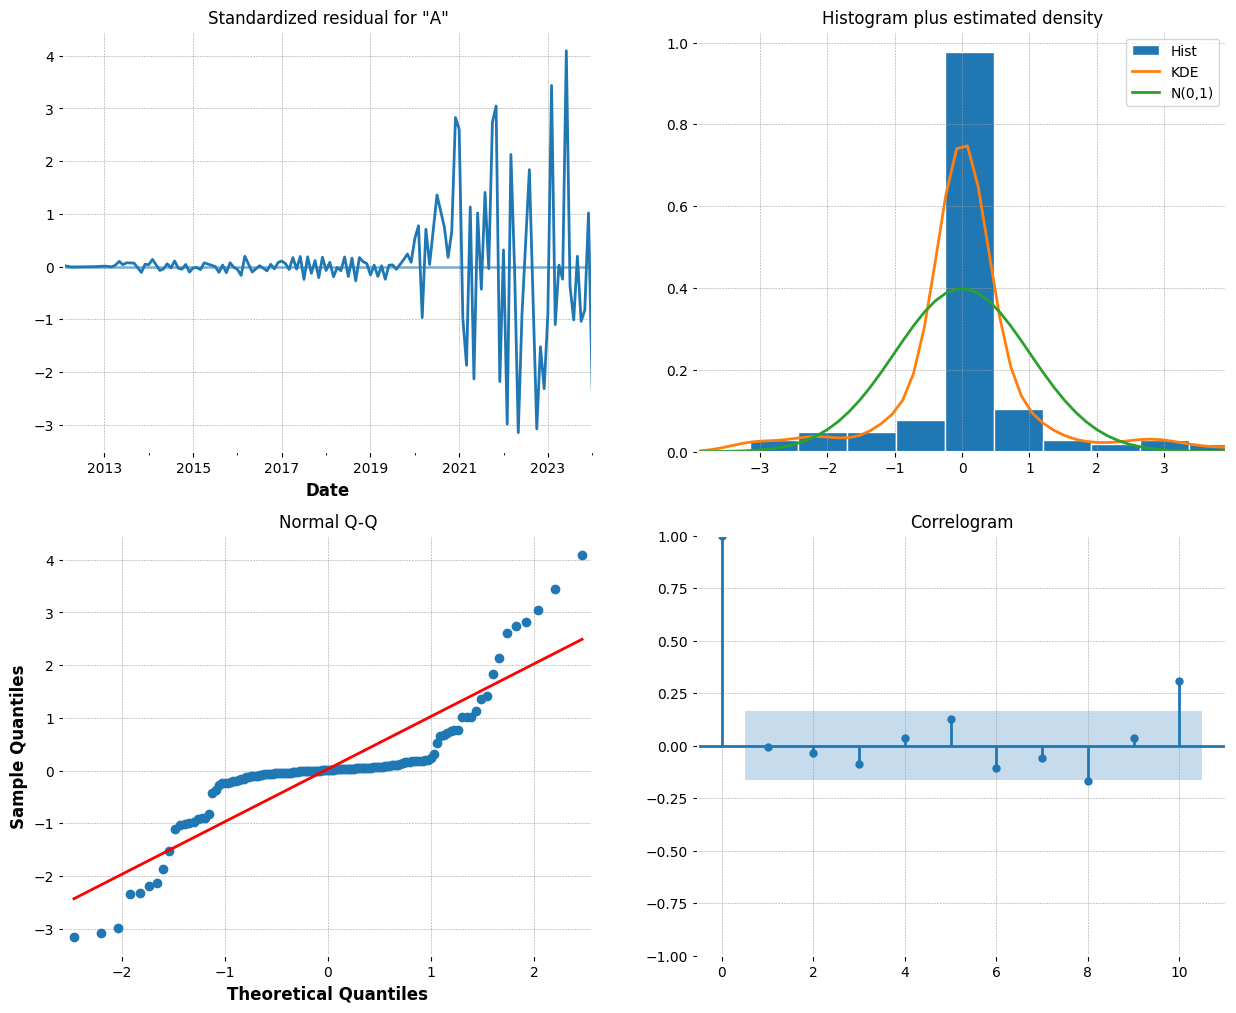

In [30]:
results.plot_diagnostics(figsize=(15, 12))
plt.show()

In [34]:
results.params

ar.L1        -0.633176
ma.L1         0.927092
ar.S.L12     -0.092563
ma.S.L12     -0.862973
sigma2      351.704051
dtype: float64

In [32]:
def plot_result_seasonal(mod, data, col_name, Ntest, seasonal_period):
    params = mod.get_params()
    d = params['order'][1]

    # In-sample data prediction
    train_pred = mod.predict_in_sample(start=d, end=-1)

    # Out-of-sample prediction
    test_pred, conf = mod.predict(n_periods=Ntest, return_conf_int=True)

    # Plotting real values, fitted values, and prediction values
    fig, ax = plt.subplots(figsize=(15, 8))
    ax.plot(data[col_name].index, data[col_name], label='Actual Values')
    ax.plot(train.index[d:], train_pred, color='green', label='Fitted Values')
    ax.plot(test.index, test_pred, label='Forecast Values')
    ax.fill_between(test.index, conf[:, 0], conf[:, 1], color='red', alpha=0.3)
    ax.legend()

    # Evaluating the model using RMSE and MAE metrics
    y_true = test[col_name].values
    rmse = np.sqrt(mean_squared_error(y_true, test_pred))
    mae = mean_absolute_error(y_true, test_pred)

    # Printing RMSE and MAE
    print('Root Mean Squared Error: ', rmse)
    print('Mean Absolute Error: ', mae)

    return rmse, mae

# Assuming `model` is the SARIMA model already trained, tesla is the data, 'Close' is the column, and Ntest is the number of test periods.
rmse, mae = plot_result_seasonal(mod, tesla, 'Adj Close', Ntest=500, seasonal_period=12)


AttributeError: 'SARIMAX' object has no attribute 'get_params'